In [36]:
import spacy
from typing import List, Tuple, Optional

import torch
from nltk import TweetTokenizer
from morfeusz2 import Morfeusz
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, pipeline
from sklearn.model_selection import train_test_split
import concurrent
from datasets import Dataset
from datasets.dataset_dict import DatasetDict
import numpy as np
from torch.nn.utils import prune
import copy
import  mlflow
import dagshub
import transformers
from transformers.onnx import FeaturesManager
from pathlib import Path

train_path = "../data/train/training_"
test_path = "../data/test/test_"

# Feature engineering

In [2]:
def load_data(path: str) -> Tuple[List[str], List[int]]:
    with open(f"{path}set_clean_only_text.txt", 'r') as file:
        lines = list(map(lambda line: line.rstrip("\n"), file.readlines()))

    with open(f"{path}set_clean_only_tags.txt", 'r') as file:
        classes = list(map(lambda line: int(line.rstrip("\n")), file.readlines()))
    return lines, classes

In [3]:
train_lines, train_classes = load_data(train_path)
test_lines, test_classes = load_data(test_path)

## Downsample non-hatespeech lines

In [4]:
non_classes = np.random.choice(np.where(np.array(train_classes) == 0)[0], size=2000, replace=False)
hatespeech_classes = np.where(np.array(train_classes) == 1)[0]

subsample_idx = np.append(non_classes, hatespeech_classes)

train_lines = np.array(train_lines)[subsample_idx].tolist()
train_classes = np.array(train_classes)[subsample_idx]

In [5]:
morfeusz = Morfeusz()
tw = TweetTokenizer()
processor = spacy.load('pl_core_news_sm')

def process_token(token) -> Optional[str]:
    if token.ent_type:
        return token.ent_type_
    if not token.is_space and not token.is_punct:
        analysis = morfeusz.analyse(token.text)
        lemma = analysis[0][2][1].split(":")[0]
        return lemma
    else:
        return None

def process_line(line: List[str]):
    return list(map(process_token, line))

def process_lines(lines: List[str]):
    lines_tw = list(map(tw.tokenize, lines))
    lines_tw = list(map(" ".join, lines_tw))
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor: 
        lines_tokenized = list(tqdm(executor.map(processor, lines_tw), total=len(lines_tw)))
    lines_tokenized_processed = list(map(process_line, lines_tokenized))
    lines_tokenized_processed = [[item for item in inner_list if item is not None and item != '@'] for inner_list in lines_tokenized_processed]
    lines_tokenized_processed = list(map(" ".join , lines_tokenized_processed))
    return lines_tokenized_processed


In [6]:
train_lines_processed = process_lines(train_lines)
test_lines_processed = process_lines(test_lines)

  0%|          | 0/2851 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
train_lines_processed, val_lines_processed, train_labels, val_labels = train_test_split(train_lines_processed, train_classes, test_size=0.2)

In [8]:
dataset_dict = {
    'train': Dataset.from_dict({'label': train_labels, 'text': train_lines_processed}),
    'val': Dataset.from_dict({'label': val_labels, 'text': val_lines_processed}),
    'test': Dataset.from_dict({'label': test_classes, 'text': test_lines_processed}),
}
dataset = DatasetDict(dataset_dict)

# Training

In [9]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("allegro/herbert-base-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def tokenize_function(line):
    return tokenizer.batch_encode_plus(line["text"], padding='longest', max_length=256, truncation=True, return_tensors='pt', add_special_tokens=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2280 [00:00<?, ? examples/s]

Map:   0%|          | 0/571 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [11]:
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    logging_dir="./logs",
    evaluation_strategy='epoch'
)

In [12]:
import gc
torch.cuda.empty_cache()
gc.collect()

600

In [13]:
dagshub.init("polish-hatespeech-sentiment-classification", "a-s-gorski", mlflow=True)

Repository initialized!

In [14]:
class LogTrainingLoss(TrainerCallback):
    def __init__(self, trainer: Trainer):
        self.trainer_ = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch = int(state.epoch)
        train_loss = self.trainer_.evaluate(eval_dataset=self.trainer_.train_dataset, metric_key_prefix="train")['train_loss']
        mlflow.log_metric("train_loss", train_loss, step=epoch)

In [15]:
with mlflow.start_run() as run:
    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer
    )
    trainer.add_callback(LogTrainingLoss(trainer))
    mlflow.transformers.autolog()
    output = trainer.train()

2023/08/07 11:28:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
/home/agorski/.cache/pypoetry/virtualenvs/src-aqY2EU_W-py3.10/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a HerbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


# Model testing

In [16]:
encoded_input = tokenizer(test_lines_processed, padding=True, truncation=True, return_tensors='pt').to("cuda")

def run_predictions(model, encoded_input):
   with torch.no_grad():
      output = model(**encoded_input)
   preds = output.logits.argmax(1).detach().tolist()
   return preds

0.871


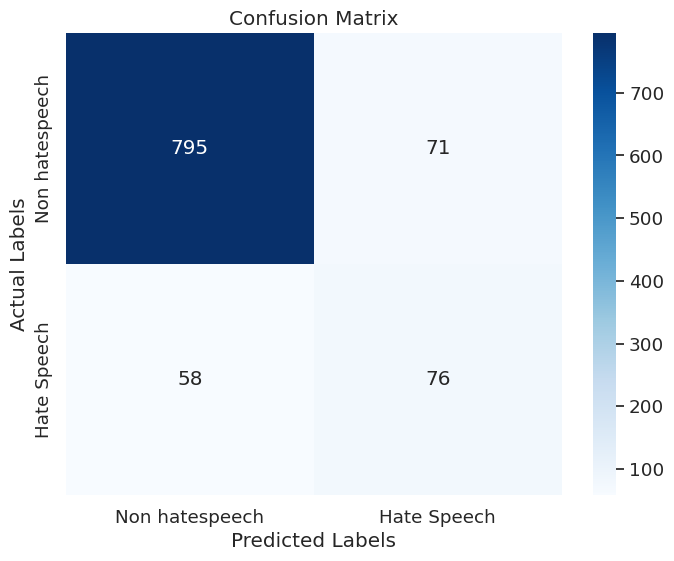

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter

preds = run_predictions(model, encoded_input)
cm = confusion_matrix(test_classes, preds)


print(accuracy_score(test_classes, preds))
labels = ["Non hatespeech", "Hate Speech"]

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(test_classes, preds)
precision = precision_score(test_classes, preds)
recall = recall_score(test_classes, preds)
f1 = f1_score(test_classes, preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)



Accuracy: 0.871
Precision: 0.5170068027210885
Recall: 0.5671641791044776
F1-score: 0.5409252669039145


### The model achieves the high accuracy of 87.4%. The model also achieves a relativly balanced relation between precision and recall making it suitable for inference on biased datasets.

# Error analysis

In [19]:
texts, y_predicted, y_true = [], [], []

for text, y_pred, y_hat in zip(test_lines, preds, test_classes):
    if y_pred == y_hat:
        continue
    else:
        texts.append(text)
        y_predicted.append(y_pred)
        y_true.append(y_hat)

false_positives = [text for text, label in zip(texts, y_predicted) if label == 1]
false_negatives = [text for text, label in zip(texts, y_predicted) if label == 0]

print(f"False positives: {len(false_positives)}")
print(f"False negatives: {len(false_negatives)}")


False positives: 71
False negatives: 58


##### After reviewing the missclassified sample the most of the false positives are caused by the use of slang that the model associates with hate-speech even when it is not.
##### The most of false negatives are subtle hatespeech that is subtle, the threat is often suggested and not experessed directly.

# Model pruning
- I am using magnitude pruning to speed up the inference for model deployment.

In [20]:
copied_model = copy.deepcopy(model)
prune_amount = 0.1
for name, module in copied_model.named_modules():
    if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.MultiheadAttention):
        prune.l1_unstructured(module, name='weight', amount=prune_amount)

In [21]:
preds_pruned = run_predictions(copied_model, encoded_input)

In [26]:
preds = run_predictions(model, encoded_input)

In [22]:
accuracy = accuracy_score(test_classes, preds_pruned)
precision = precision_score(test_classes, preds_pruned)
recall = recall_score(test_classes, preds_pruned)
f1 = f1_score(test_classes, preds_pruned)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.871
Precision: 0.5174825174825175
Recall: 0.5522388059701493
F1-score: 0.5342960288808665


In [23]:
texts, y_predicted, y_true = [], [], []

for text, y_pred, y_hat in zip(test_lines, preds_pruned, test_classes):
    if y_pred == y_hat:
        continue
    else:
        texts.append(text)
        y_predicted.append(y_pred)
        y_true.append(y_hat)

false_positives = [text for text, label in zip(texts, y_predicted) if label == 1]
false_negatives = [text for text, label in zip(texts, y_predicted) if label == 0]

print(f"False positives: {len(false_positives)}")
print(f"False negatives: {len(false_negatives)}")


False positives: 69
False negatives: 60


# Converting to onnx

In [24]:
copied_model = copied_model.to("cpu")
model = model.to("cpu")

In [25]:
feature = "sequence-classification"


In [50]:
classification_pipeline = pipeline("text-classification", tokenizer=tokenizer, model=model)

In [51]:
classification_pipeline(["@anonymized_account @anonymized_account Ale ten gość wchodził jej w cyce i go popchnęła, a liścia ładnie przyjęła, także pisdzielstwo zawsze na dnie", "nie podobał mi się mecz"])

[{'label': 'LABEL_1', 'score': 0.9985277652740479},
 {'label': 'LABEL_0', 'score': 0.9998860359191895}]

In [52]:
model_kind, model_onnx_config = FeaturesManager.check_supported_model_or_raise(model, feature=feature)
onnx_config = model_onnx_config(model.config)

In [58]:
onnx_inputs, onnx_outputs = transformers.onnx.export(
        model=classification_pipeline.model,
        preprocessor=tokenizer,
        config=onnx_config,
        opset=13,
        output=Path("../models/model.onnx")
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================
